In [1]:
num_epochs = 50

In [2]:

# Import the data for each company
import pandas as pd

#Empresa
df = pd.read_csv('GCARSOA1.csv')
df

#Define the target
target = "Cierre"

df = df.drop(['Fecha','% var.','Vol.'], axis=1)
df

,Cierre,Apertura,Máximo,Mínimo
0,130.48,129.38,132.00,128.76
1,128.91,127.39,129.53,125.34
2,125.49,127.25,129.71,124.50
3,126.67,131.76,133.46,126.51
4,132.07,131.99,134.22,131.73
...,...,...,...,...
1143,73.91,73.59,74.99,73.59
1144,73.35,74.52,74.95,72.86
1145,74.97,73.51,75.00,73.51
1146,74.32,73.30,75.00,73.30


In [3]:
#Define the features
features = list(df.columns.difference([]))
features

['Cierre', 'Apertura', 'Máximo', 'Mínimo']

In [4]:
#Define the training and test percentages
training_percentage = 0.67
size = int(len(df) * training_percentage)

df_train = df.loc[:size].copy()
df_test = df.loc[size:].copy()

In [5]:
#Normalize the data
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [6]:
#LSTM training
from utils import SequenceDataset
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

#Sets the seed for generating random numbers
torch.manual_seed(101) 

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 4])
Target shape: torch.Size([1])


In [7]:
#Define functions to train/test the model
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    accuracy = 1.0 / (avg_loss + 1e-7)

    print(f"Train loss: {avg_loss}")
    print(f"Train accuracy: {accuracy}")
    return avg_loss, accuracy


def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    accuracy = 1.0 / (avg_loss + 1e-7)
    print(f"Test loss: {avg_loss}")
    print(f"Test accuracy: {accuracy}")
    return avg_loss, accuracy

In [8]:
#Define the parameters to train the model
from utils import ShallowRegressionLSTM
from torch import nn

learning_rate = 0.0001
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

classical_loss_train = []
classical_acc_train = []
classical_loss_test = []
classical_acc_test = []
print("Untrained test\n--------")
test_loss, test_accuracy = test_model(test_loader, model, loss_function)
print()
classical_loss_test.append(test_loss)
classical_acc_test.append(test_accuracy)

for ix_epoch in range(0,num_epochs):
  print(f"Epoch {ix_epoch}\n---------")
  train_loss, train_accuracy = train_model(train_loader, model, loss_function, optimizer=optimizer)
  test_loss, test_accuracy = test_model(test_loader, model, loss_function)
  classical_loss_train.append(train_loss)
  classical_acc_train.append(train_accuracy)
  classical_loss_test.append(test_loss)
  classical_acc_test.append(test_accuracy)

Untrained test
--------
Test loss: 2.5460627001948595
Test accuracy: 0.39276328923366166

Epoch 0
---------
Train loss: 0.7321508375621082
Train accuracy: 1.3658385842265897
Test loss: 1.240343188626156
Test accuracy: 0.8062284120613351
Epoch 1
---------
Train loss: 0.19180654430205457
Train accuracy: 5.213583729796206
Test loss: 0.3715075590582638
Test accuracy: 2.6917345460249833
Epoch 2
---------
Train loss: 0.05112530051278569
Train accuracy: 19.55974896959321
Test loss: 0.2226431286959139
Test accuracy: 4.491490739948799
Epoch 3
---------
Train loss: 0.03727369225597995
Train accuracy: 26.828501729377077
Test loss: 0.18624632243063508
Test accuracy: 5.369230651248811
Epoch 4
---------
Train loss: 0.028106848070468878
Train accuracy: 35.57839141741148
Test loss: 0.1663712085678562
Test accuracy: 6.010651768072979
Epoch 5
---------
Train loss: 0.021132921196144343
Train accuracy: 47.31931088880217
Test loss: 0.13040650462813477
Test accuracy: 7.668323263622903
Epoch 6
---------
Trai

In [9]:
#Save the cmodel
torch.save(model.state_dict(), "./cmodelCARSO" )

In [10]:
#Define the function to predict using the model
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output

In [11]:
#Compare the real value vs. the predicted value
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

      Cierre  Model forecast
0     130.48      129.995956
1     128.91      128.113174
2     125.49      126.211739
3     126.67      127.575012
4     132.07      131.929352
...      ...             ...
1143   73.91       74.019699
1144   73.35       73.759941
1145   74.97       74.179749
1146   74.32       74.126419
1147   73.89       73.208885

[1149 rows x 2 columns]


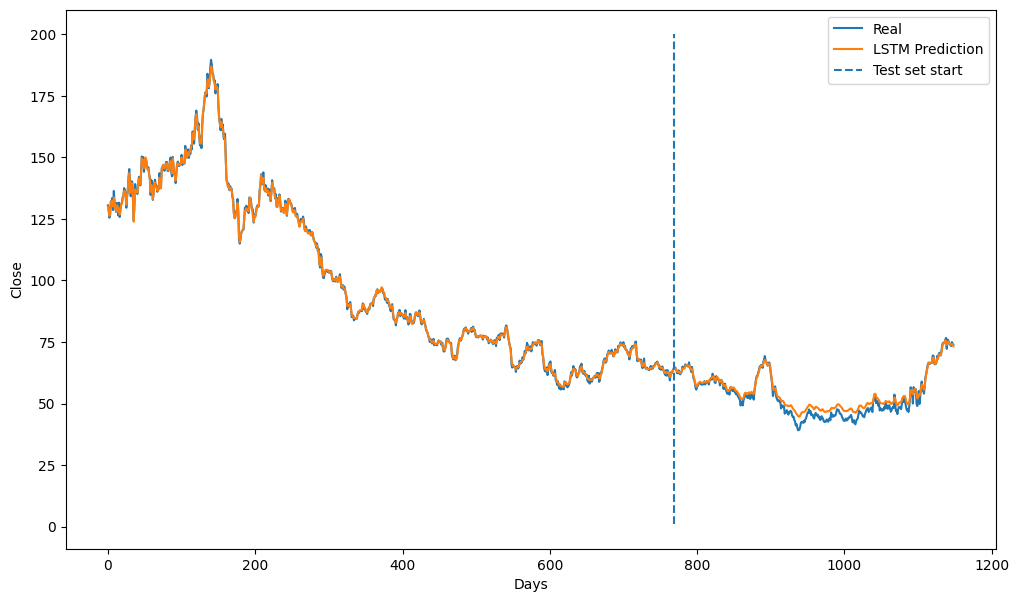

In [12]:
plt.figure(figsize=(12, 7))
plt.plot(range(0,len(df) + 1), df_out["Cierre"], label = "Real")
plt.plot(range(0,len(df) + 1), df_out["Model forecast"], label = "LSTM Prediction")
plt.ylabel('Close')
plt.xlabel('Days')
plt.vlines(size, ymin = 1, ymax = 200, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

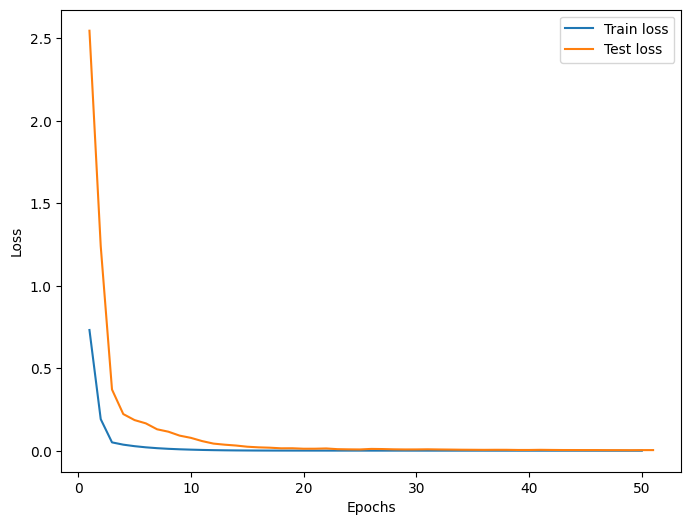

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), classical_loss_train, label = "Train loss")
plt.plot(range(1, num_epochs + 2), classical_loss_test, label="Test loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [14]:
#Quantum prediction
from utils import QShallowRegressionLSTM

learning_rate = 0.05
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits = 4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 4)


In [15]:
#Train the quantum model
import time

quantum_loss_train = []
quantum_acc_train = []
quantum_loss_test = []
quantum_acc_test = []
print("Untrained test\n--------")
start = time.time()
test_loss, test_accuracy = test_model(test_loader, Qmodel, loss_function)
end = time.time()
print("Execution time", end - start)
quantum_loss_test.append(test_loss)

for ix_epoch in range(0, num_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss, train_accuracy = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss, test_accuracy = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_acc_train.append(train_accuracy)
    quantum_loss_test.append(test_loss)
    quantum_acc_test.append(test_accuracy)

Untrained test
--------
Test loss: 1.8957448329648745
Test accuracy: 0.5274971240123729
Execution time 18.93084406852722
Epoch 0
---------
Train loss: 0.061318407483513235
Train accuracy: 16.30828996072468
Test loss: 0.10411003631930225
Test accuracy: 9.6052126656816
Execution time 79.55857181549072
Epoch 1
---------
Train loss: 0.005339842460907229
Train accuracy: 187.2679354357884
Test loss: 0.13488159361845758
Test accuracy: 7.413904534952823
Execution time 79.2730324268341
Epoch 2
---------
Train loss: 0.003090194554784142
Train accuracy: 323.5937488392107
Test loss: 0.09571823408891522
Test accuracy: 10.447319309496907
Execution time 79.45966601371765
Epoch 3
---------
Train loss: 0.0023157321964269923
Train accuracy: 431.81021558593983
Test loss: 0.07039117402729664
Test accuracy: 14.206306304560073
Execution time 79.34110522270203
Epoch 4
---------
Train loss: 0.0019233823843642075
Train accuracy: 519.8903863788398
Test loss: 0.05059723861000908
Test accuracy: 19.76388536376855


In [16]:
#Save the qmodel
torch.save(Qmodel.state_dict(), "./qmodelCARSO" )

In [17]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_loader, Qmodel).numpy()

df_out_Q = pd.concat((df_train, df_test))[[target, ystar_col_Q]]

for c in df_out_Q.columns:
    df_out_Q[c] = df_out_Q[c] * target_stdev + target_mean

print(df_out_Q)

      Cierre  Model forecast
0     130.48      130.430405
1     128.91      128.554947
2     125.49      125.521408
3     126.67      127.168388
4     132.07      132.498795
...      ...             ...
1143   73.91       73.931328
1144   73.35       73.309792
1145   74.97       74.842636
1146   74.32       74.265800
1147   73.89       73.598724

[1149 rows x 2 columns]


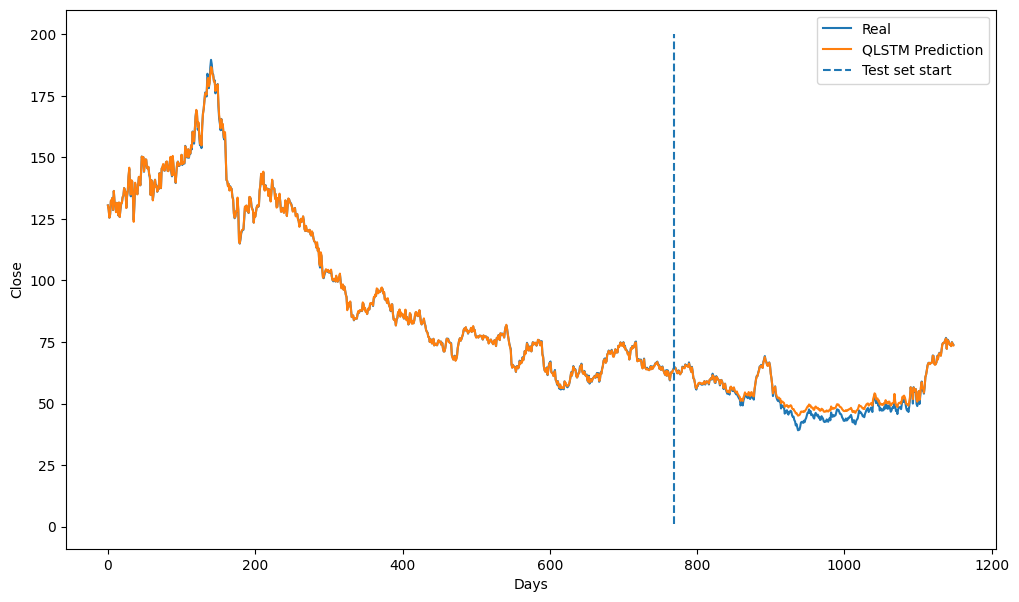

In [18]:
plt.figure(figsize=(12, 7))
plt.plot(range(0,len(df) + 1), df_out_Q["Cierre"], label = "Real")
plt.plot(range(0,len(df) + 1), df_out_Q["Model forecast"], label = "QLSTM Prediction")
plt.ylabel('Close')
plt.xlabel('Days')
plt.vlines(size, ymin = 1, ymax = 200, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

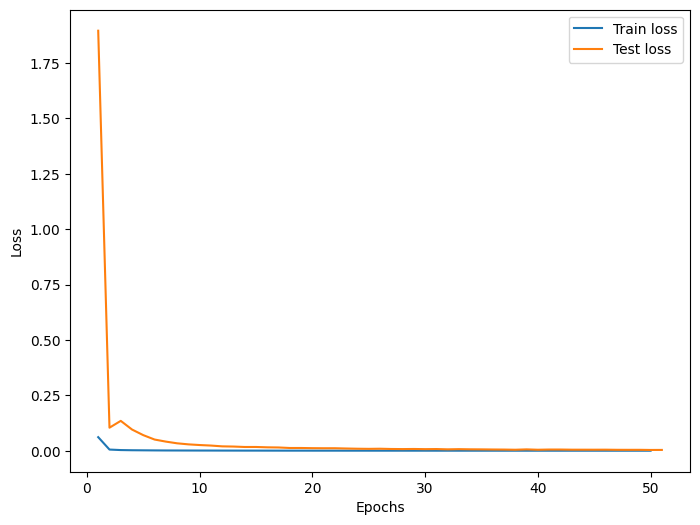

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), quantum_loss_train, label = "Train loss")
plt.plot(range(1, num_epochs + 2), quantum_loss_test, label="Test loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

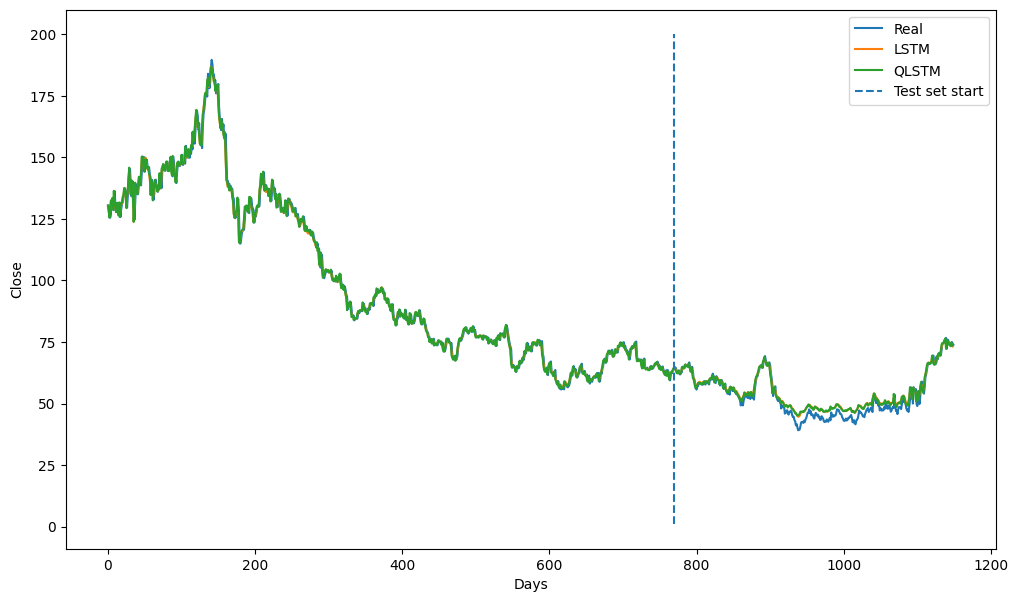

In [25]:
##Comparison between classical and quantum
plt.figure(figsize=(12, 7))
plt.plot(range(1, len(df) + 2), df_out_Q["Cierre"], label = "Real")
plt.plot(range(0, len(df) + 1), df_out["Model forecast"], label = "LSTM")
plt.plot(range(0, len(df) + 1), df_out_Q["Model forecast"], label = "QLSTM")
plt.ylabel('Close')
plt.xlabel('Days')
plt.vlines(size, ymin = 1, ymax = 200, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()